# HR Diagram

In [1]:
import pandas as pd

In [2]:
df_stars = pd.read_csv(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\venv\Exam\Data\stars.csv")

Quick data exploration

In [3]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# Assign unique integers from 0 to 6 to each star type
df_stars['Star type'] = le.fit_transform(df_stars['Star type'])
labels = le.inverse_transform(df_stars['Star type'])
class_names = le.classes_

In [4]:
import seaborn as sns
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\venv\Utilities\utils.py")
from Utilities import plot_settings
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Real Labels')

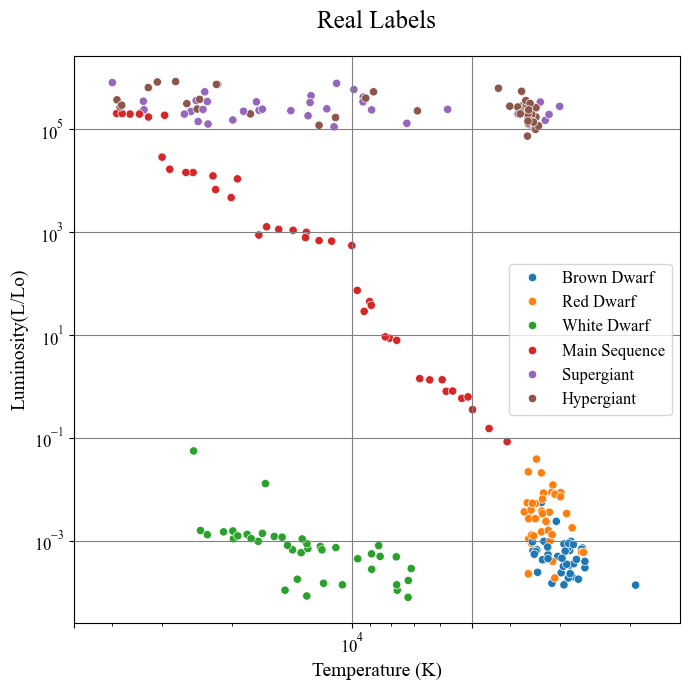

In [5]:
fig = plt.figure(figsize=(7, 7))
sns.scatterplot(data=df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue=labels)
plt.xscale('log')
plt.yscale('log')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)
plt.title('Real Labels')

## Unsupervised analysis

In [123]:
import numpy as np
X = np.vstack([df_stars['Absolute magnitude(Mv)'].to_numpy(), df_stars['Luminosity(L/Lo)'].to_numpy(), df_stars['Radius(R/Ro)'].to_numpy(), df_stars['Temperature (K)'].to_numpy()]).T

In [124]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA

In [125]:
X_scaled = StandardScaler().fit_transform(X)
y = df_stars['Star type'].to_numpy()

In [126]:
pca = PCA(n_components=4, random_state=32)
X_pca = pca.fit_transform(X_scaled)

Text(0, 0.5, 'Explained variance ratio')

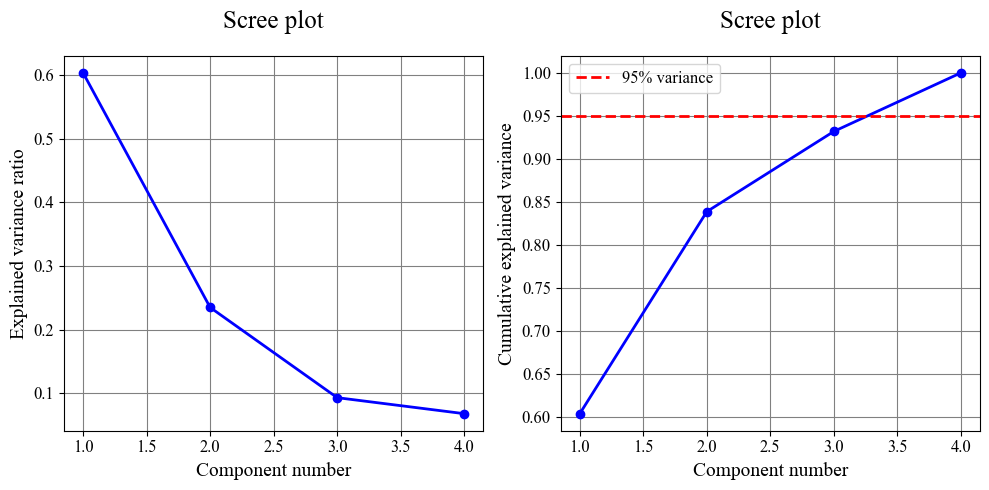

In [127]:
fig, axs = plt.subplots(1, 2)
axs[1].plot(range(1,5), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-', color='blue')
axs[1].set_title('Scree plot')
axs[1].set_xlabel('Component number')
axs[1].axhline(0.95, 0, 1, linestyle='--', color='red', label='95% variance')
axs[1].set_ylabel('Cumulative explained variance')
axs[1].legend()

axs[0].plot(range(1,5), pca.explained_variance_ratio_, marker='o', linestyle='-', color='blue')
axs[0].set_title('Scree plot')
axs[0].set_xlabel('Component number')
axs[0].set_ylabel('Explained variance ratio')

We can cluster now!\
I can do better, cross validate both on PCA components number and on number of components of GM model

In [128]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

In [129]:
# Define pipeline
pipe = Pipeline([
    ('pca', PCA()),
    ('cluster', GaussianMixture())
])

# Hyperparameter grid to search
param_grid = {
    'pca__n_components': [2, 3, 4],
    'cluster__n_components': [2, 3, 4, 5, 6]
}

custom_cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [130]:
# Grid search with accuracy scoring
grid = GridSearchCV(pipe, param_grid, cv=custom_cv, scoring='accuracy')
grid.fit(X_scaled, y)

print(f"Best parameters: {grid.best_params_}")
print(f"Best cross-validation accuracy: {grid.best_score_:.4f}")

# Use best model to predict
best_model = grid.best_estimator_
y_pred = best_model.predict(X_scaled)

print(f"Training accuracy with best model: {accuracy_score(y, y_pred):.4f}")

Best parameters: {'cluster__n_components': 6, 'pca__n_components': 4}
Best cross-validation accuracy: 0.3583
Training accuracy with best model: 0.1125


C:\Users\ricca\AppData\Local\Temp\ipykernel_19360\4122606400.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


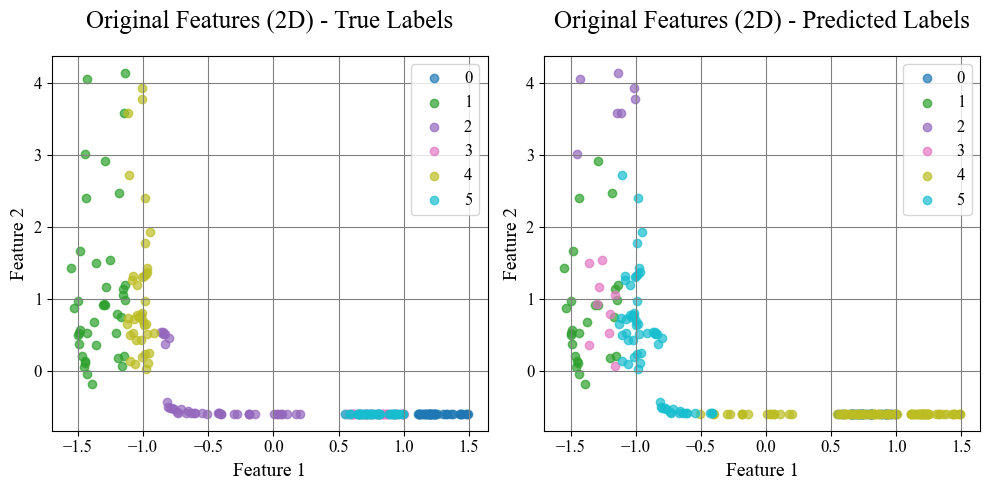

In [131]:
X_vis = X_scaled[:, :2]
y_true = y
y_pred = best_model.predict(X_scaled)

unique_labels = np.unique(y_true)
colors = plt.cm.get_cmap('tab10', len(unique_labels))

# Left: True labels
plt.subplot(1, 2, 1)
for i, label in enumerate(unique_labels):
    idx = y_true == label
    plt.scatter(X_vis[idx, 0], X_vis[idx, 1], label=str(label), color=colors(i), alpha=0.7)
plt.title("Original Features (2D) - True Labels")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

# Right: Predicted labels
plt.subplot(1, 2, 2)
for i, label in enumerate(unique_labels):
    idx = y_pred == label
    plt.scatter(X_vis[idx, 0], X_vis[idx, 1], label=str(label), color=colors(i), alpha=0.7)
plt.title("Original Features (2D) - Predicted Labels")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

plt.tight_layout()
plt.show()


Data are too close to eachother, clustering like this is difficult task (also the number of clusters is not right!)\
What if I force the right number of clusters?

In [132]:
gm = GaussianMixture(n_components=6)

C:\Users\ricca\AppData\Local\Temp\ipykernel_19360\1629035967.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


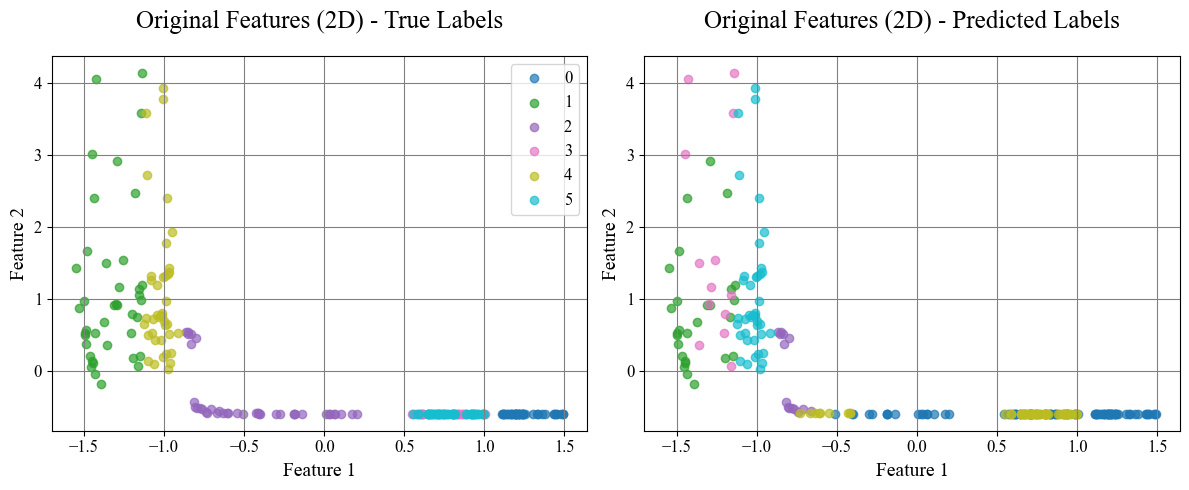

In [135]:
X_vis = X_scaled[:, :2]
y_true = y
y_pred = gm.fit_predict(X_pca)

unique_labels = np.unique(y_true)
colors = plt.cm.get_cmap('tab10', len(unique_labels))

plt.figure(figsize=(12, 5))

# Left: True labels
plt.subplot(1, 2, 1)
for i, label in enumerate(unique_labels):
    idx = y_true == label
    plt.scatter(X_vis[idx, 0], X_vis[idx, 1], label=str(label), color=colors(i), alpha=0.7)
plt.title("Original Features (2D) - True Labels")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

# Right: Predicted labels
plt.subplot(1, 2, 2)
for i, label in enumerate(unique_labels):
    idx = y_pred == label
    plt.scatter(X_vis[idx, 0], X_vis[idx, 1], color=colors(i), alpha=0.7)
plt.title("Original Features (2D) - Predicted Labels")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.tight_layout()

## Supervised Classification (Manifold)

In [79]:
from sklearn.preprocessing import RobustScaler
from sklearn.manifold import Isomap
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [80]:
S = RobustScaler().fit_transform(X)

In [83]:
# Define pipeline
pipe = Pipeline([
    ('Scaler', RobustScaler()),
    ('isomap', Isomap()),
    ('gpc', GaussianProcessClassifier(random_state=42))
])

# Hyperparameter grid to search
param_grid = {
    'isomap__n_neighbors': [5, 10, 15],
    'isomap__n_components': [2, 3, 5],
    'gpc__max_iter_predict': [100, 200]
}

custom_cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [84]:
# Grid search with accuracy scoring
grid = GridSearchCV(pipe, param_grid, cv=custom_cv, scoring='accuracy')
grid.fit(S, y)

print(f"Best parameters: {grid.best_params_}")
print(f"Best cross-validation accuracy: {grid.best_score_:.4f}")

# Use best model to predict
best_model = grid.best_estimator_
y_pred = best_model.predict(X_scaled)

print(f"Training accuracy with best model: {accuracy_score(y, y_pred):.4f}")

c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\scipy\sparse\_index.py:168: SparseEff

c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\scipy\sparse\_index.py:168: SparseEff

Best parameters: {'gpc__max_iter_predict': 100, 'isomap__n_components': 5, 'isomap__n_neighbors': 10}
Best cross-validation accuracy: 0.9667
Training accuracy with best model: 0.9792


C:\Users\ricca\AppData\Local\Temp\ipykernel_19360\108470601.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


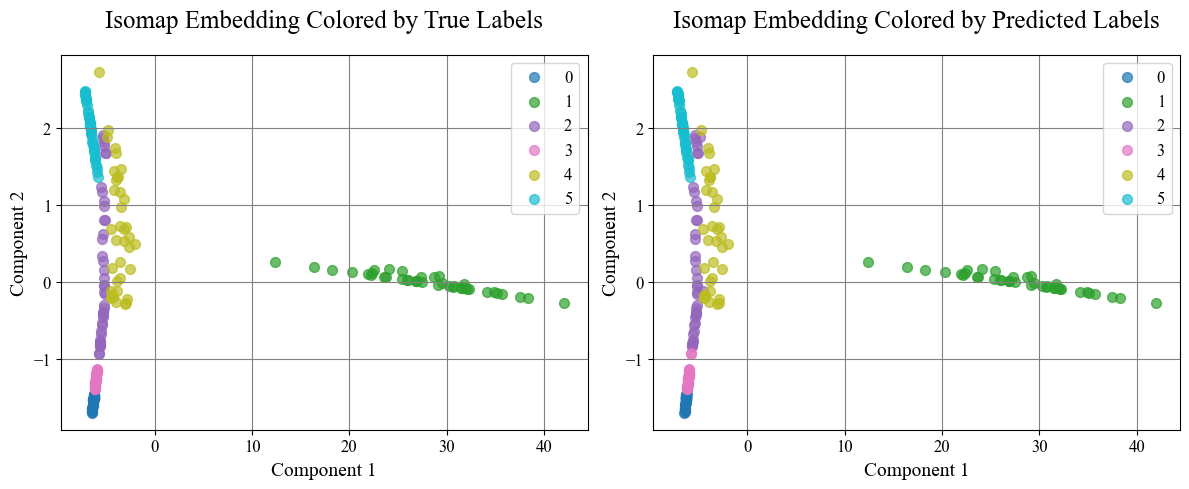

In [85]:
# Reduce to 2D for plotting (use the best n_components found or 2 if available)
n_components = grid.best_params_.get('isomap__n_components', 2)

# Transform original scaled data using the best Isomap from the pipeline
isomap = best_model.named_steps['isomap']
X_embedded = isomap.transform(X_scaled)

# True labels and predicted labels
y_true = y
y_pred = best_model.predict(X_scaled)

# Create a color map based on true labels
unique_labels = np.unique(y_true)
colors = plt.cm.get_cmap('tab10', len(unique_labels))

plt.figure(figsize=(12, 5))

# Plot 1: True labels
plt.subplot(1, 2, 1)
for i, label in enumerate(unique_labels):
    idx = y_true == label
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], 
                label=str(label), alpha=0.7, s=50, color=colors(i))
plt.title("Isomap Embedding Colored by True Labels")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()

# Plot 2: Predicted labels
plt.subplot(1, 2, 2)
for i, label in enumerate(unique_labels):
    idx = y_pred == label
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], 
                label=str(label), alpha=0.7, s=50, color=colors(i))
plt.title("Isomap Embedding Colored by Predicted Labels")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.tight_layout()
plt.show()

Accuracy sky-rocketed! I have successfully classified data!

In [92]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.model_selection import cross_val_predict

In [119]:
classes = np.unique(y)
y_bin = label_binarize(y_pred, classes=classes)
n_classes = y_bin.shape[1]


# Predict probabilities
y_score = best_model.predict_proba(S)
#cross_val_predict(grid.best_estimator_, X, y_pred, cv=custom_cv, method='predict_proba')

# Plot ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

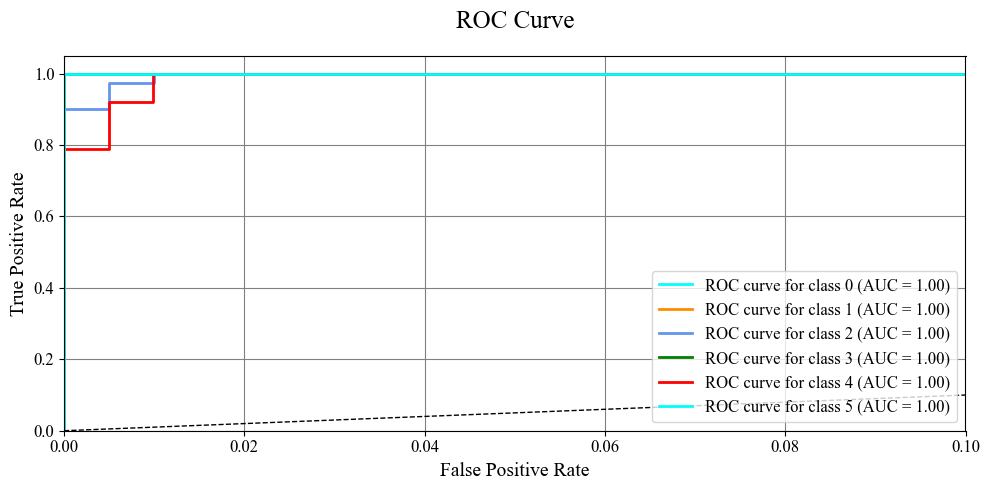

In [122]:
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'ROC curve for class {classes[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 0.1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")